# Predicting Student Performance
### Creating Models for Training and Testing

Data is the Student Performance data set from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Student+Performance

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import mode
from tabulate import tabulate
from sklearn.model_selection import KFold, train_test_split

# metric scores for each model
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
# metric scores for visualizations
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

# Models used for Project
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

### All preprocessing done in stu_perf_eda.ipynb

In [37]:
all_stu = pd.read_csv("~/introToDataScience/project/Student-Performance-Predictor/data/encoded_student_per.csv")

### Creating Train/Test Split and k-fold CV

In [38]:
train_df, test_df = train_test_split(all_stu, test_size=0.3, random_state=7)  # splitting data on 80/20 (train/test)

In [39]:
folds = KFold(n_splits=5, shuffle=True)

### Splitting data into Features and Response

In [40]:
# slicing data into features and response for train and test
x_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:,-1].values

x_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:,-1].values

In [41]:
headers = ["Fold", "Accuracy", "Precision", "Recall", "f1", "AUROC"] # headers for metric table

### Creating Baseline Model

In [42]:
re_var = all_stu.iloc[:,-1].values
most = mode(re_var, keepdims = True)
print(f"Mode of the Response Variable: {most[0]}")

Mode of the Response Variable: [1]


In [129]:
header = ["Accuracy", "Precision", "Recall", "f1", "AUROC"] # headers for metric table

baseline_preds = np.ones_like(re_var)  # creating numpy array of most common class 1

accuracy = accuracy_score(re_var, baseline_preds)
precision = precision_score(re_var, baseline_preds)
recall = recall_score(re_var, baseline_preds)
f1 = f1_score(re_var, baseline_preds)
roc_auc = roc_auc_score(re_var, baseline_preds)

results = [[accuracy, precision, recall, f1, roc_auc]]

print(tabulate(results, headers=header, floatfmt=".2f"))

  Accuracy    Precision    Recall    f1    AUROC
----------  -----------  --------  ----  -------
      0.63         0.63      1.00  0.78     0.50


Not very good as expected. Recall makes sense as TP / (TP + FN) = 1, there is 0 FN

## Random Forest Model

#### 5 k-fold Cross Validation using just the Training Data Set

In [152]:
results = []

for fold, (train_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=3)
    clf_rf.fit(x_train[train_idx], y_train[train_idx])
    preds = clf_rf.predict(x_train[val_idx])
    actual = y_train[val_idx]

    accuracy = accuracy_score(actual, preds)
    precision = precision_score(actual, preds)
    recall = recall_score(actual, preds)
    f1 = f1_score(actual, preds)
    roc_auc = roc_auc_score(actual, preds)

    results.append([fold+1, accuracy, precision, recall, f1, roc_auc])

print(tabulate(results, headers=headers, floatfmt=".2f"))

  Fold    Accuracy    Precision    Recall    f1    AUROC
------  ----------  -----------  --------  ----  -------
     1        0.93         0.93      0.95  0.94     0.93
     2        0.93         0.95      0.93  0.94     0.93
     3        0.92         0.93      0.96  0.94     0.91
     4        0.93         0.95      0.95  0.95     0.92
     5        0.94         0.95      0.96  0.96     0.92


#### Fitting model to full training set and then predicting never seen test data set

In [170]:
header = ["Accuracy", "Precision", "Recall", "f1", "AUROC"] # headers for metric table
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=3)
clf_rf.fit(x_train, y_train)
predict = clf_rf.predict(x_test)

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
f1 = f1_score(y_test, predict)
roc_auc = roc_auc_score(y_test, predict)

results = [[accuracy, precision, recall, f1, roc_auc]]

print(tabulate(results, headers=header, floatfmt=".2f"))

  Accuracy    Precision    Recall    f1    AUROC
----------  -----------  --------  ----  -------
      0.88         0.90      0.90  0.90     0.87


#### Important Features in Random Forest

In [172]:
features = train_df.columns
important_features = clf_rf.feature_importances_

for i in range(len(important_features)):
    if important_features[i] != 0.0:
        print(f"{features[i]}:  {important_features[i]}")

school:  0.008490999389130184
sex:  0.002662845152835231
age:  0.009425896577719457
address:  0.0015795463698129399
famsize:  0.0005352412279265933
Pstatus:  0.0002026605221824885
Medu:  0.028063498899021024
Fedu:  0.018720665622810013
Mjob:  0.0031603420099798503
Fjob:  0.0028332741506870564
reason:  0.0031392962741026396
guardian:  0.004518261468952359
traveltime:  0.0043422614420611455
studytime:  0.015368446587923131
failures:  0.11351628604886502
schoolsup:  0.0024155676814804866
famsup:  5.598503843691122e-05
paid:  0.00507479048896621
activities:  0.00029296745474213586
nursery:  0.0011742265359832656
higher:  0.04570704714851159
internet:  0.006389030227902086
romantic:  0.003183756341417145
famrel:  0.004357018406583367
freetime:  0.005843835382023426
goout:  0.0068263358590591435
Dalc:  0.007533944458883052
Walc:  0.006654848513409049
health:  0.0025780520537958458
absences:  0.01079995817654929
G1:  0.2889247274789756
G2:  0.3856283870092721


## XGBoost Model

#### 5 k-fold Cross Validation using just the Training Data Set

In [157]:
results = []

for fold, (train_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    clf_xg = xgb.XGBClassifier(colsample_bytree=0.5, eta=0.01, max_depth=3, n_estimators=100, subsample=0.8)
    clf_xg.fit(x_train[train_idx], y_train[train_idx])
    preds = clf_xg.predict(x_train[val_idx])
    actual = y_train[val_idx]

    accuracy = accuracy_score(actual, preds)
    precision = precision_score(actual, preds)
    recall = recall_score(actual, preds)
    f1 = f1_score(actual, preds)
    roc_auc = roc_auc_score(actual, preds)

    results.append([fold+1, accuracy, precision, recall, f1, roc_auc])

print(tabulate(results, headers=headers, floatfmt=".2f"))

  Fold    Accuracy    Precision    Recall    f1    AUROC
------  ----------  -----------  --------  ----  -------
     1        0.96         0.98      0.96  0.97     0.96
     2        0.95         0.95      0.95  0.95     0.94
     3        0.92         0.93      0.96  0.94     0.91
     4        0.92         0.95      0.93  0.94     0.91
     5        0.91         0.94      0.93  0.93     0.90


#### Fitting model to full training set and then predicting never seen test data set

In [160]:
header = ["Accuracy", "Precision", "Recall", "f1", "AUROC"] # headers for metric table
clf_xg = xgb.XGBClassifier(colsample_bytree=0.5, eta=0.01, max_depth=3, n_estimators=100, subsample=0.8)
clf_xg.fit(x_train, y_train)
pred = clf_xg.predict(x_test)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)

results = [[accuracy, precision, recall, f1, roc_auc]]

print(tabulate(results, headers=header, floatfmt=".2f"))

  Accuracy    Precision    Recall    f1    AUROC
----------  -----------  --------  ----  -------
      0.90         0.93      0.90  0.92     0.90


In [161]:
importance_scores = clf_xg.get_booster().get_score(importance_type='gain')
sorted_scores = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

# Get a list of feature names in the order of decreasing importance scores
feature_names = [x[0] for x in sorted_scores]

# Print the list of feature names used in the model
print("Features used in the model:")
print(feature_names)

Features used in the model:
['f31', 'f30', 'f14', 'f20', 'f6', 'f19', 'f7', 'f15', 'f17', 'f26', 'f27', 'f13', 'f8', 'f21', 'f3', 'f5', 'f25', 'f0', 'f28', 'f29', 'f23', 'f1', 'f12', 'f24', 'f22', 'f2', 'f9', 'f10', 'f11', 'f16', 'f4']


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1000x1000 with 0 Axes>

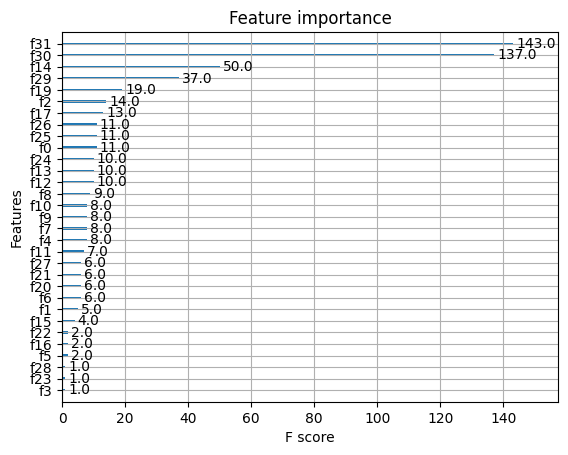

In [162]:
plt.figure(figsize=(10, 10))
xgb.plot_importance(clf_xg)

#### Confusion Matrix

In [163]:
rf_y_pred = clf_rf.predict(x_test)
rf_confusion_matrix = confusion_matrix(y_test, predict)

xgb_y_pred = clf_xg.predict(x_test)
xgb_confusion_matrix = confusion_matrix(y_test, pred)

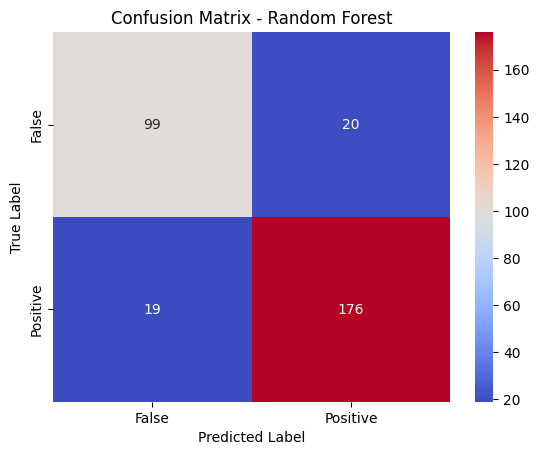

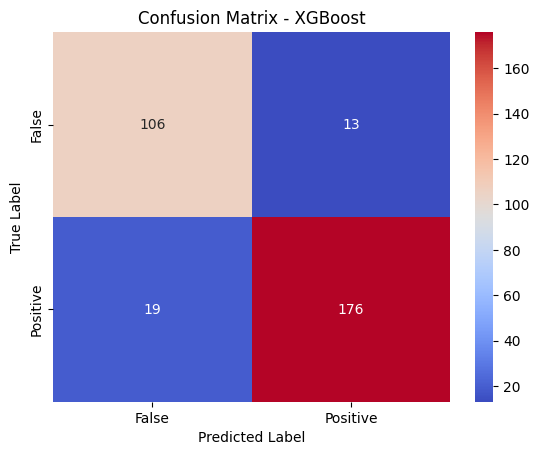

In [164]:
sb.heatmap(rf_confusion_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=['False', 'Positive'], yticklabels=['False', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

sb.heatmap(xgb_confusion_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=['False', 'Positive'], yticklabels=['False', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost')
plt.show()


### Probablities for PR curve and AUROC

In [165]:
prob_rf = clf_rf.predict_proba(x_test)
preds_rf = prob_rf[:, 1]

prob_xg = clf_xg.predict_proba(x_test)
preds_xg = prob_xg[:, 1]

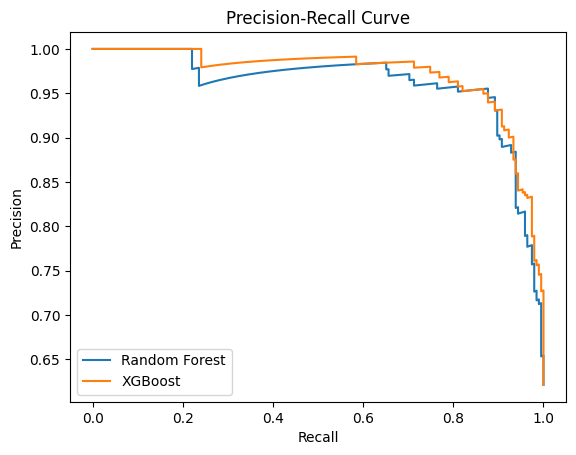

In [166]:
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, preds_rf)
xg_precision, xg_recall, xg_thresholds = precision_recall_curve(y_test, preds_xg)

plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.plot(xg_recall, xg_precision, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

#### AUROC Visulizations

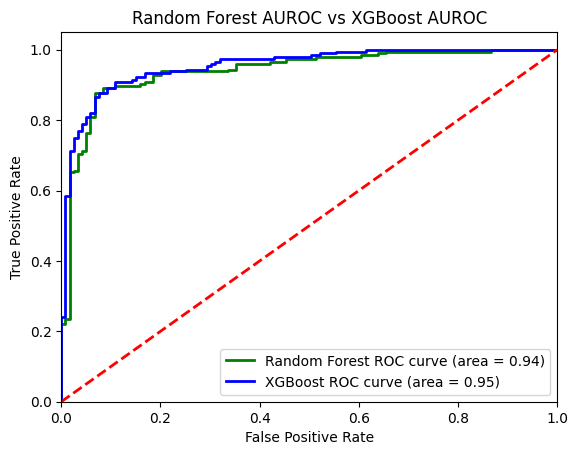

In [167]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, preds_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, preds_xg)
roc_auc_xg = auc(fpr_xg, tpr_xg)

plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_xg, tpr_xg, color='blue', lw=2, label='XGBoost ROC curve (area = %0.2f)' % roc_auc_xg)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest AUROC vs XGBoost AUROC')
plt.legend(loc="lower right")
plt.show()